# Stochastic Volatility Models

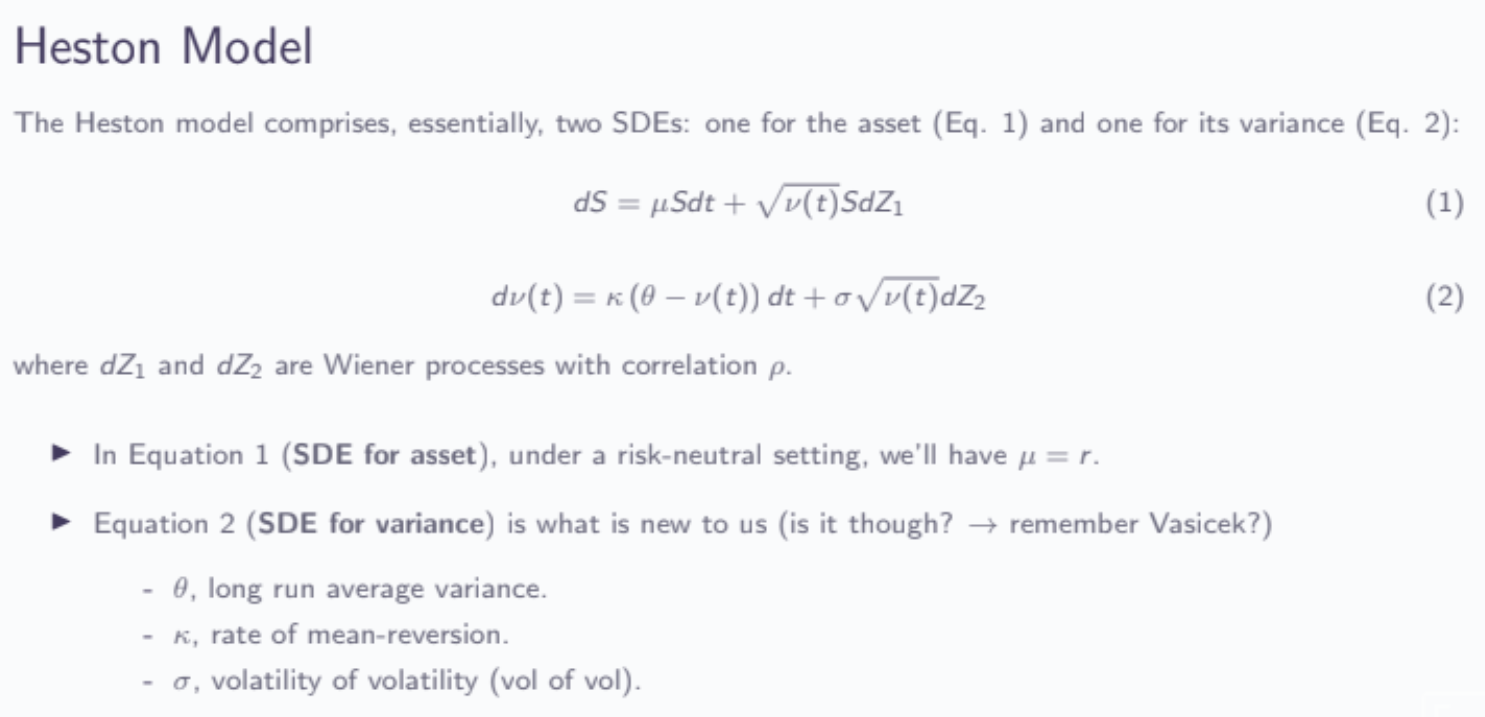

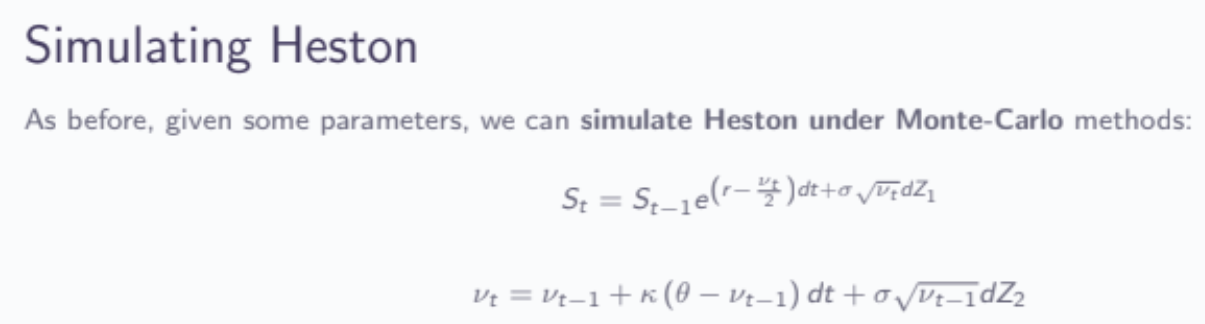

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

def SDE_vol(v0, kappa, theta, sigma, T, M, Ite, rand, row, cho_matrix):
    dt = T / M  # T = maturity, M = number of time steps
    v = np.zeros((M + 1, Ite), dtype=np.float64)
    v[0] = v0
    sdt = np.sqrt(dt)  # Sqrt of dt
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        v[t] = np.maximum(
            0,
            v[t - 1]
            + kappa * (theta - v[t - 1]) * dt
            + np.sqrt(v[t - 1]) * sigma * ran[row] * sdt,
        )
    return v

def Heston_paths(S0, r, v, row, cho_matrix):
    S = np.zeros((M + 1, Ite), dtype=float)
    S[0] = S0
    sdt = np.sqrt(dt)
    for t in range(1, M + 1, 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[row] * sdt)

    return S

def random_number_gen(M, Ite):
    rand = np.random.standard_normal((2, M + 1, Ite))
    return rand

v0 = 0.04
kappa_v = 2
sigma_v = 0.3
theta_v = 0.04
rho = -0.9

S0 = 100  # Current underlying asset price
r = 0.05  # Risk-free rate
M0 = 50  # Number of time steps in a year
T = 1  # Number of years
M = int(M0 * T)  # Total time steps
Ite = 10000  # Number of simulations
dt = T / M  # Length of time step

In [8]:
# Generating random numbers from standard normal
rand = random_number_gen(M, Ite)


# Covariance Matrix
covariance_matrix = np.zeros((2, 2), dtype=np.float64)
covariance_matrix[0] = [1.0, rho]
covariance_matrix[1] = [rho, 1.0]
cho_matrix = np.linalg.cholesky(covariance_matrix)
cho_matrix

array([[ 1.        ,  0.        ],
       [-0.9       ,  0.43588989]])

In [11]:
# Volatility process paths
V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, Ite, rand, 1, cho_matrix)

# Underlying price process paths
S = Heston_paths(S0, r, V, 0, cho_matrix)

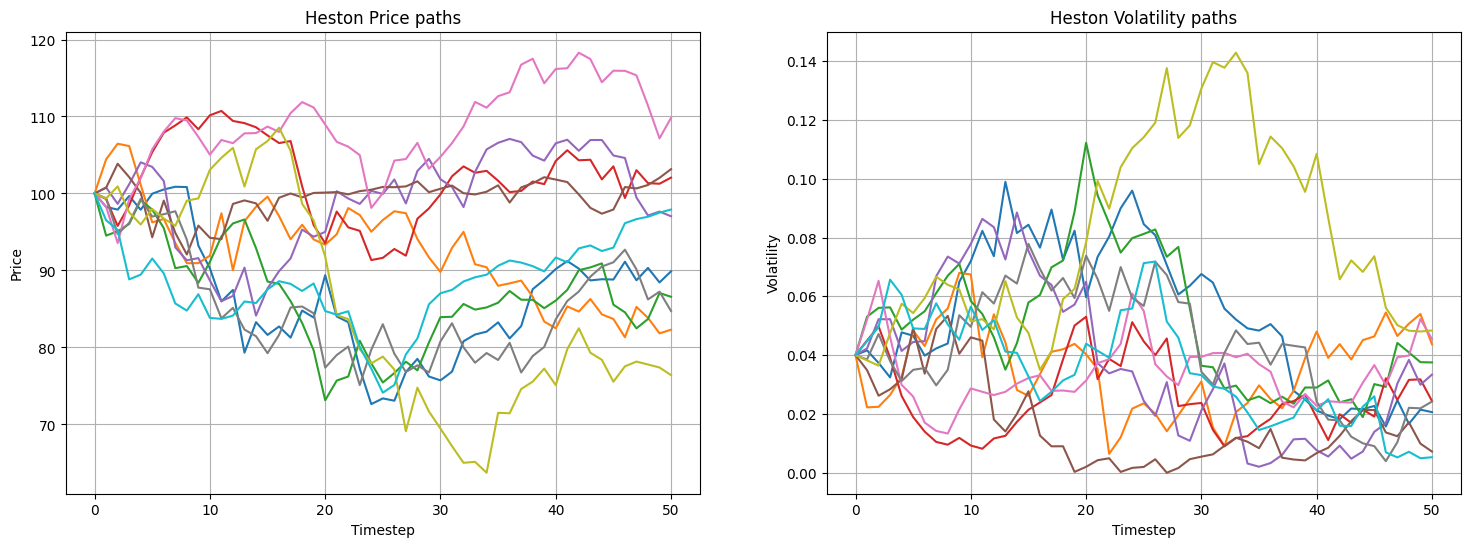

In [12]:
def plot_paths(n):
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(range(len(S)), S[:, :n])
    ax1.grid()
    ax1.set_title("Heston Price paths")
    ax1.set_ylabel("Price")
    ax1.set_xlabel("Timestep")

    ax2.plot(range(len(V)), V[:, :n])
    ax2.grid()
    ax2.set_title("Heston Volatility paths")
    ax2.set_ylabel("Volatility")
    ax2.set_xlabel("Timestep")


plot_paths(10)